# Rate of similarity between two texts

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib.colors as mcolors
import seaborn as sns
#Avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
sample_submision=pd.read_csv("sample_submission.csv")

In [3]:
print("train:",train.shape)
print("test:",test.shape)
print("sample_submission:",sample_submision.shape)

train: (36473, 5)
test: (36, 4)
sample_submission: (36, 2)


In [4]:
train.dtypes

id          object
anchor      object
target      object
context     object
score      float64
dtype: object

In [5]:
#¿are there na's?
train.isna().sum()

id         0
anchor     0
target     0
context    0
score      0
dtype: int64

In [6]:
test.dtypes

id         object
anchor     object
target     object
context    object
dtype: object

In [7]:
sample_submision.dtypes

id       object
score     int64
dtype: object

In [8]:
sample_submision.score.value_counts()

0    36
Name: score, dtype: int64

# Row data

## Anchor

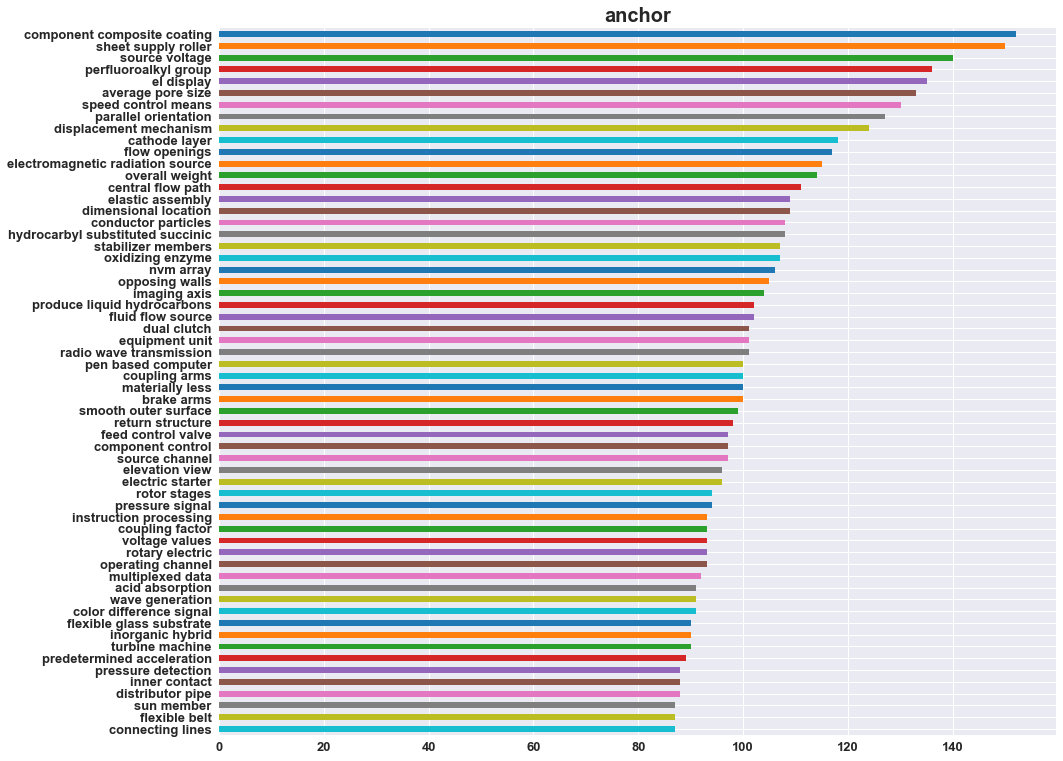

In [9]:
train.anchor.value_counts().head(60).plot.barh(figsize=(15,13),color=mcolors.TABLEAU_COLORS).invert_yaxis()
plt.xticks(weight = 'bold',fontsize=13 )
plt.yticks(weight = 'bold',fontsize=13 )
plt.title("anchor",fontsize=20,fontweight= 'bold')
plt.show()

## Context

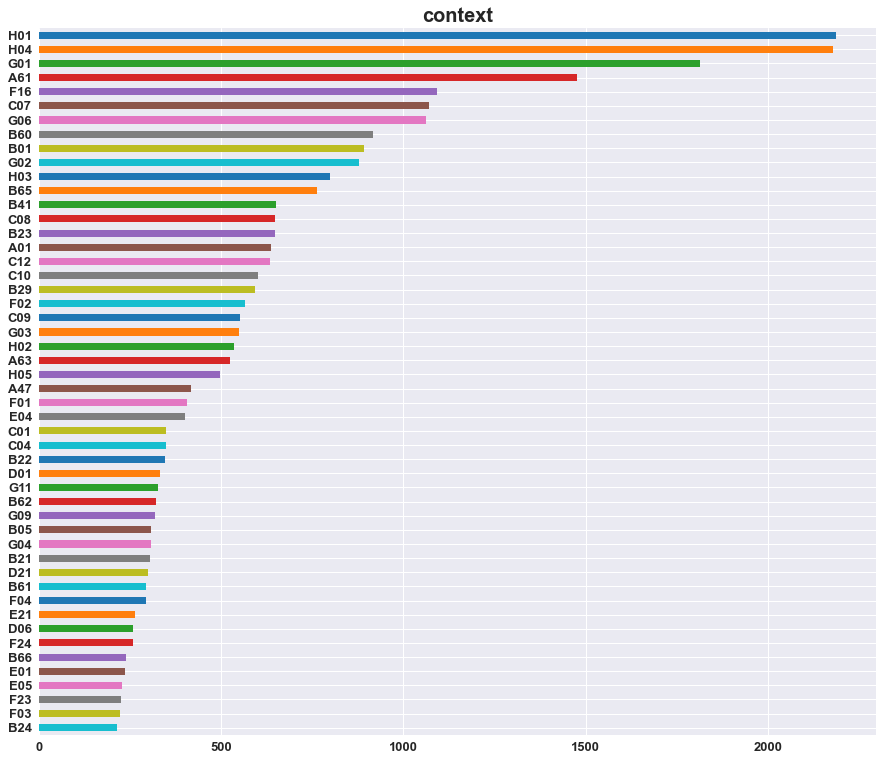

In [10]:
train.context.value_counts().head(50).plot.barh(figsize=(15,13),color=mcolors.TABLEAU_COLORS).invert_yaxis()
plt.xticks(weight = 'bold',fontsize=13 )
plt.yticks(weight = 'bold',fontsize=13 )
plt.title("context",fontsize=20,fontweight= 'bold')
plt.show()

The idea is only keeping the letters and not followed numbers in order to avoid overfitting

In [11]:
train["context"]=train.context.str.replace("[0-9]+","")

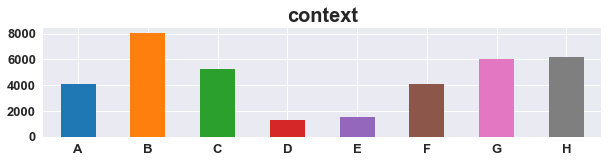

In [12]:
train.context.value_counts().sort_index().plot.bar(figsize=(10,2),rot=0,color=mcolors.TABLEAU_COLORS)
plt.xticks(weight = 'bold',fontsize=13 )
plt.yticks(weight = 'bold',fontsize=13 )
plt.title("context",fontsize=20,fontweight= 'bold')
plt.show()

For practical purposes, transforming from label to integer:

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train["context"]=le.fit_transform(train["context"])

## Target

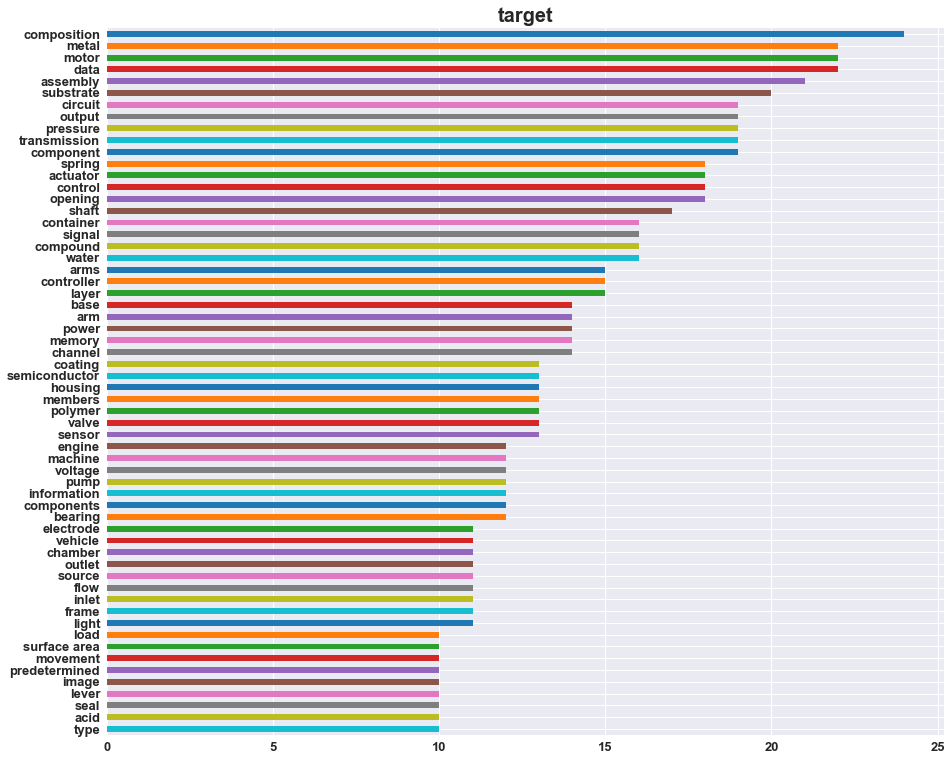

In [14]:
train.target.value_counts().head(60).plot.barh(figsize=(15,13),color=mcolors.TABLEAU_COLORS).invert_yaxis()
plt.xticks(weight = 'bold',fontsize=13)
plt.yticks(weight = 'bold',fontsize=13 )
plt.title("target",fontsize=20,fontweight= 'bold')
plt.show()

## Score

In [15]:
train["score"]=train.score*100
train["score"]=train["score"].astype("int32")

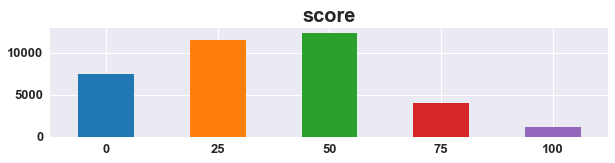

In [16]:
train.score.value_counts().sort_index().plot.bar(figsize=(10,2),rot=0,color=mcolors.TABLEAU_COLORS)
plt.xticks(weight = 'bold',fontsize=13)
plt.yticks(weight = 'bold',fontsize=13 )
plt.title("score",fontsize=20,fontweight= 'bold')
plt.show()

# Feature engineering

## Cosine, Jaccard similarity and euclidian distance

In [17]:
#Cleaning row data
def clean_data(text):
    signs=[",",";",":","¿","?","$","#",".","¡","!"]
    text=text.lower()
    for sign in signs:
        text=text.replace(sign,"")
    text=text.split(" ")
    text=[word for word in text if word !=""]
    return text

#Replacing two similar words with respect to the first one
def words_similarity(word1,word2):
    w=word2
    if len(word2)>=4:
        for i in range(3,len(word2)):
            if word2[:i+1] in word1:
                w=word1
                break
    return w

#Word counter
def counter(text):
    counter = {}
    for word in text:
        if word in counter:
            counter[word]+=1
        else:
            counter[word]=1
    return counter

In [18]:
#Getting parameteres: Cosine, Jaccard and Euclidian distance
def feature_eng(text1,text2):
    text1=clean_data(text1)
    text2=clean_data(text2)
    for x1 in range(len(text1)):
        for x2 in range(len(text2)):
            text2[x2]=words_similarity(text1[x1],text2[x2])
    t1=pd.Series(counter(text1))
    t2=pd.Series(counter(text2))
    T=pd.DataFrame({"text1":t1,"text2":t2})
    T.fillna(0,inplace=True)
    cosine = np.dot(T.text1,T.text2)/(np.linalg.norm(T.text1)*np.linalg.norm(T.text2))
    jaccard=np.intersect1d(t1.index,t2.index).size/T.shape[0]
    distance=np.linalg.norm(T.text1-T.text2)
    return pd.Series([cosine,jaccard, distance])

In [19]:
%%time
train[['cosine','jaccard','distance']]= train[['anchor','target']].apply(lambda x: feature_eng(*x),axis=1)

Wall time: 42.8 s


## Correlation analysis

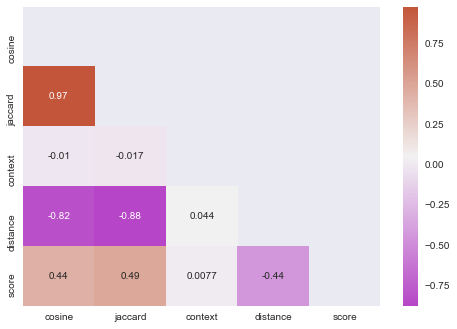

In [20]:
corr =train[["cosine","jaccard","context","distance","score"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(300, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
plt.show()

In [21]:
train_fe= pd.get_dummies(train,columns=["context"],drop_first=True)
train_fe.drop(columns=["id","anchor","target","score"],inplace=True,axis=1)
train_fe['score']=train.score

In [22]:
train_fe.iloc[np.random.randint(0,train_fe.shape[0],10),:]

,cosine,jaccard,distance,context_1,context_2,context_3,context_4,context_5,context_6,context_7,score
30599,0.000000,0.000000,2.000000,0,0,0,0,0,0,1,25
34707,0.000000,0.000000,1.732051,0,0,0,1,0,0,0,25
12838,0.500000,0.333333,1.414214,1,0,0,0,0,0,0,0
36131,0.000000,0.000000,1.732051,0,1,0,0,0,0,0,0
14657,0.408248,0.250000,1.732051,1,0,0,0,0,0,0,0
4602,0.816497,0.666667,1.000000,1,0,0,0,0,0,0,50
27275,0.774597,0.600000,1.414214,0,0,0,0,0,1,0,50
31519,0.333333,0.200000,2.000000,0,0,0,0,1,0,0,0
13122,0.000000,0.000000,1.732051,0,0,0,0,0,1,0,50
20454,0.408248,0.250000,1.732051,0,0,1,0,0,0,0,50


# Supervised methods

In [23]:
#Taking notes of calculing time
import datetime as dt
def round_seconds(timedelta):
    seconds= int(timedelta.total_seconds())
    rounded_timedelta= dt.timedelta(seconds=seconds)  
    return(rounded_timedelta) 

Splitting dataset:

In [24]:
from sklearn.model_selection import train_test_split,cross_validate
data_train , data_test= train_test_split(train_fe,test_size=0.75,random_state=141,
                                         stratify=train_fe["score"]) 

In [25]:
#Data train
x_train = data_train.drop(columns="score")
y_train = data_train.score

In [26]:
#Data test
x_test = data_test.drop(columns="score")
y_test = data_test.score

In [27]:
from sklearn.model_selection import GridSearchCV, KFold
main_kfold = KFold(5, shuffle=True, random_state=49)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

## KNN

In [28]:
n_neighbors= np.arange(3,95,2)
from sklearn.neighbors import KNeighborsClassifier

#create a knn model
knn = KNeighborsClassifier(n_jobs=-1,p=1)
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": n_neighbors}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=main_kfold,scoring='accuracy',n_jobs=-1)

#fit the model to data
initial_time = dt.datetime.now()
knn_gscv.fit(x_train, y_train)
final_time= dt.datetime.now()
time_knn=round_seconds(final_time - initial_time)

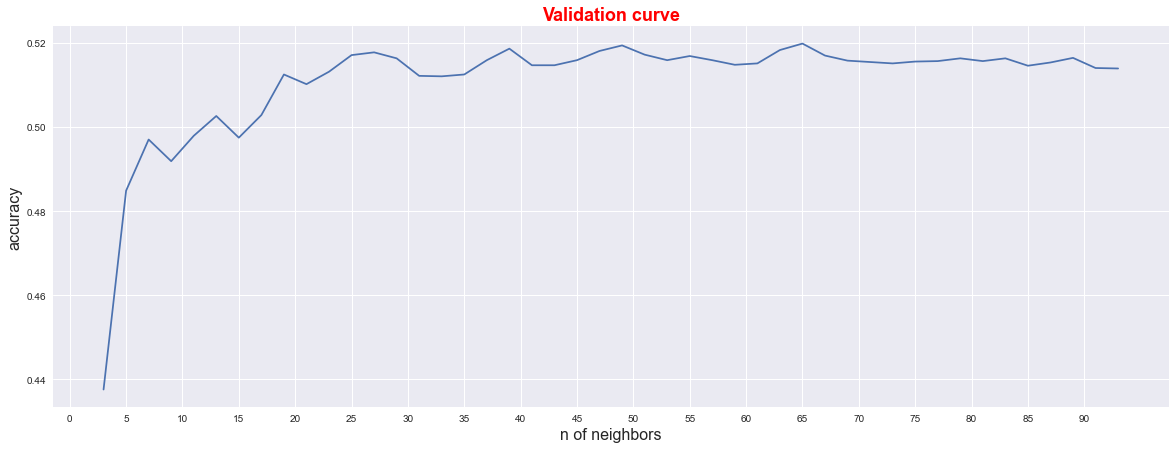

In [29]:
plt.figure(figsize=(20,7))
plt.plot(n_neighbors, knn_gscv.cv_results_['mean_test_score']) 
plt.title("Validation curve",fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of neighbors',fontsize=16)
plt.xticks(range(0,n_neighbors.max(),5))
plt.ylabel('accuracy',fontsize=16)
plt.show()    

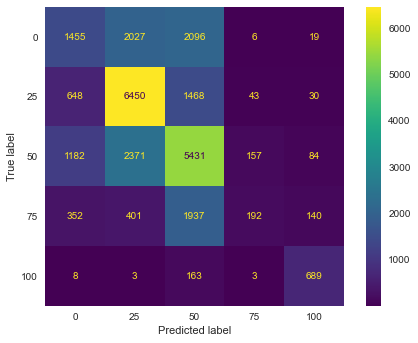

Accuracy: 0.52


In [30]:
y_predict=knn_gscv.predict(x_test)
cm = confusion_matrix(y_test, y_predict, labels=knn_gscv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn_gscv.classes_)
disp.plot()
plt.grid(ls='--',lw=0) 
plt.show()
accuracy_knn= accuracy_score(y_predict,y_test).round(3)
print("Accuracy:",accuracy_knn)

## Random Forest

In [31]:
N=np.array([15,50,75,100,200,250,300,350,400])
from sklearn.ensemble import RandomForestClassifier 

#create a rf model
rf = RandomForestClassifier(n_jobs=-1)
#create a dictionary of all values we want to test for n estimators
param_grid = {"n_estimators": N}

#use gridsearch to test all values for n_neighbors
rf_gscv = GridSearchCV(rf, param_grid, cv=main_kfold,scoring='accuracy',n_jobs=-1)

#fit the model to data
initial_time = dt.datetime.now()
rf_gscv.fit(x_train, y_train)
final_time= dt.datetime.now()
time_rf=round_seconds(final_time - initial_time)

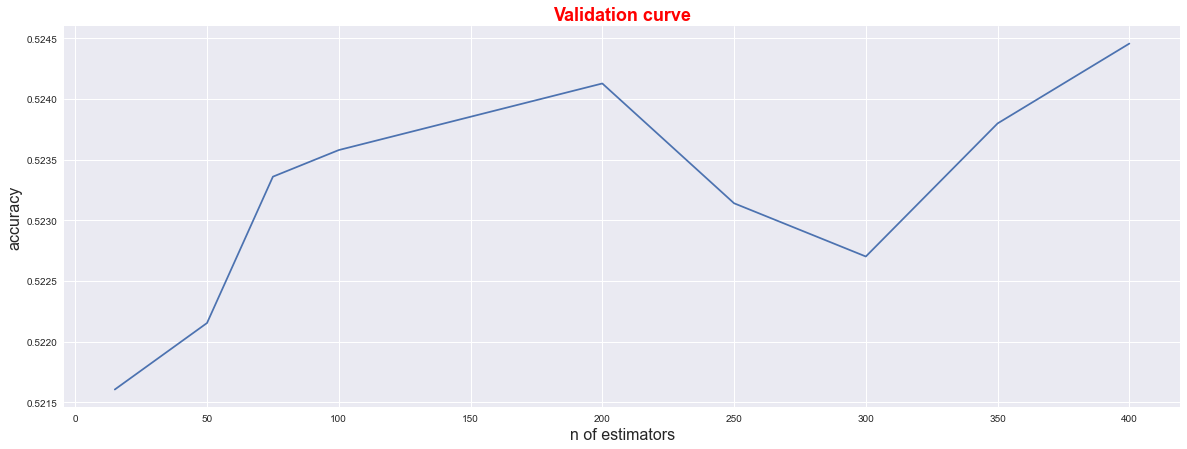

In [32]:
plt.figure(figsize=(20,7))
plt.plot(N, rf_gscv.cv_results_['mean_test_score']) 
plt.title("Validation curve",fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.ylabel('accuracy',fontsize=16)
plt.show() 

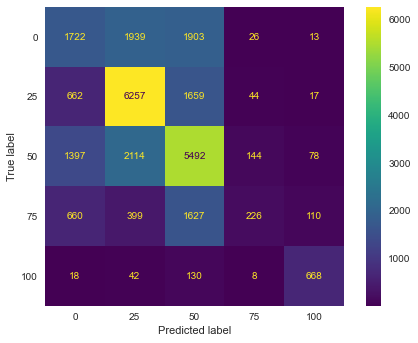

Accuracy: 0.525


In [33]:
y_predict=rf_gscv.predict(x_test)
cm = confusion_matrix(y_test, y_predict, labels=rf_gscv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn_gscv.classes_)
disp.plot()
plt.grid(ls='--',lw=0) 
plt.show()
accuracy_rf = accuracy_score(y_predict,y_test).round(3)
print("Accuracy:",accuracy_rf)

## Gradient Boosting

In [34]:
N=np.array([15,50,100,300,500,750])
from sklearn.ensemble import GradientBoostingClassifier 

#create a gb model
gb = GradientBoostingClassifier()
#create a dictionary of all values we want to test for n estimators
param_grid = {"n_estimators": N}

#use gridsearch to test all values for n estimators
gb_gscv = GridSearchCV(gb, param_grid, cv=main_kfold,scoring='accuracy',n_jobs=-1)

#fit the model to data
initial_time = dt.datetime.now()
gb_gscv.fit(x_train, y_train)
final_time= dt.datetime.now()
time_gb=round_seconds(final_time - initial_time)

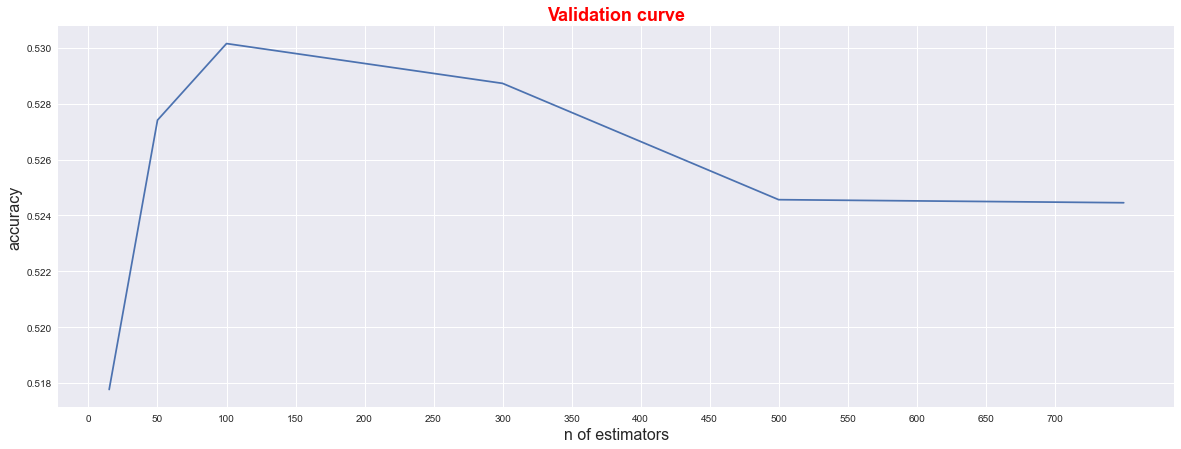

In [35]:
plt.figure(figsize=(20,7))
plt.plot(N, gb_gscv.cv_results_['mean_test_score']) 
plt.title("Validation curve",fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.xticks(range(0,N.max(),50))
plt.ylabel('accuracy',fontsize=16)
plt.show()    

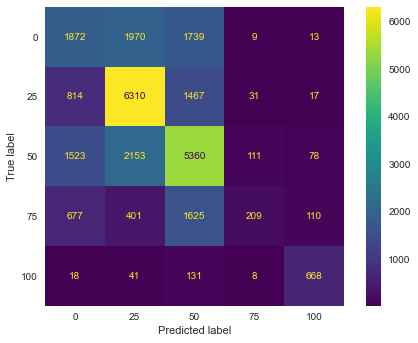

Accuracy: 0.527


In [36]:
y_predict=gb_gscv.predict(x_test)
cm = confusion_matrix(y_test, y_predict, labels=gb_gscv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gb_gscv.classes_)
disp.plot()
plt.grid(ls='--',lw=0) 
plt.show()
accuracy_gb = accuracy_score(y_predict,y_test).round(3)
print("Accuracy:",accuracy_gb)

## Neural Network

In the case, it's more convenient to use a classical network.

In [37]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

In [38]:
def create_model(neurons1,neurons2):
    model=Sequential()
    model.add(Input(x_train.shape[1]))#Numbers of attributes
    model.add(Dense(neurons1, activation='relu'))
    model.add(Dense(neurons2, activation='relu')) 
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.01),# gradient descent method
                  loss='sparse_categorical_crossentropy',# metric on neurons 
                  metrics=['accuracy'])# metric on output
    return(model) 

In [39]:
model = KerasClassifier(model=create_model, verbose=0)
N1=np.arange(10,110,step=10)
N2=np.arange(10,110,step=10)
param_grid=dict(model__neurons1=N1,model__neurons2=N2)
nn_gscv = GridSearchCV(model, param_grid, cv=main_kfold,scoring='accuracy',n_jobs=-1)

#fit model to data
initial_time = dt.datetime.now()
nn_gscv.fit(x_train,y_train,epochs=30, batch_size=10,verbose=0)
final_time= dt.datetime.now()
time_nn=round_seconds(final_time - initial_time)

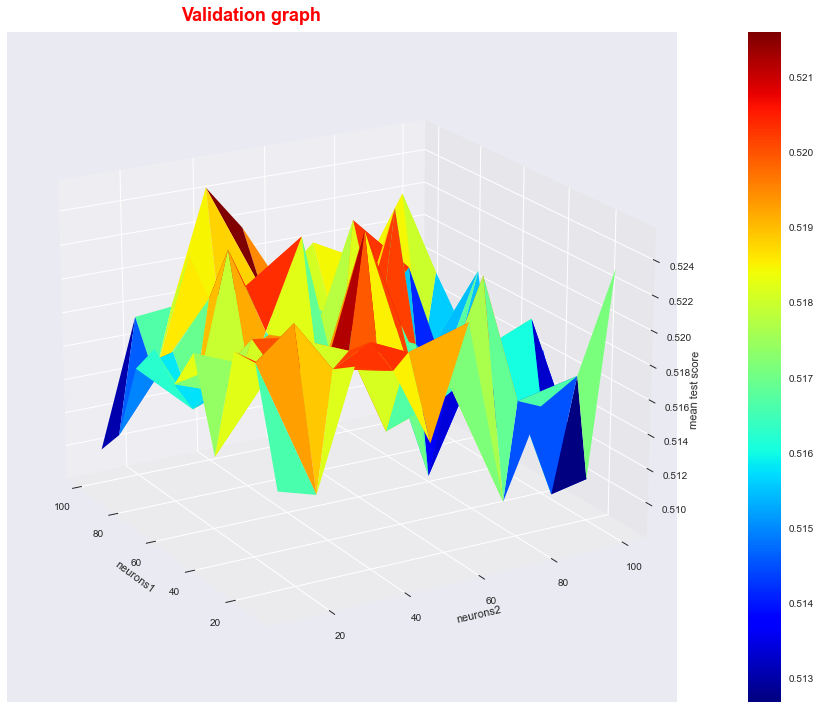

In [40]:
from mpl_toolkits import mplot3d
from matplotlib import cm

df=pd.DataFrame(nn_gscv.cv_results_['params'])
df.columns=df.columns.str.replace("model__","")
df["mean_test_score"]=nn_gscv.cv_results_['mean_test_score']

#3-d graph
fig = plt.figure(figsize=(20,10))
ax  = fig.add_subplot(111,projection='3d')
surf=ax.plot_trisurf(df.neurons1, df.neurons2, df.mean_test_score,cmap=cm.jet, linewidth=0.2)
fig.colorbar(surf)
ax.invert_zaxis()
ax.set_xlabel('neurons1',)
ax.set_ylabel('neurons2')
ax.set_zlabel('mean test score')
ax.view_init(-160, 30)
plt.suptitle('Validation graph',fontsize=18,color='red',fontweight="bold")
fig.tight_layout()
plt.show()

In [41]:
#maximum
df[df['mean_test_score']==df['mean_test_score'].max()]

,neurons1,neurons2,mean_test_score
34,40,50,0.525443


In [42]:
#minimum
df[df['mean_test_score']==df['mean_test_score'].min()]

,neurons1,neurons2,mean_test_score
57,60,80,0.508335


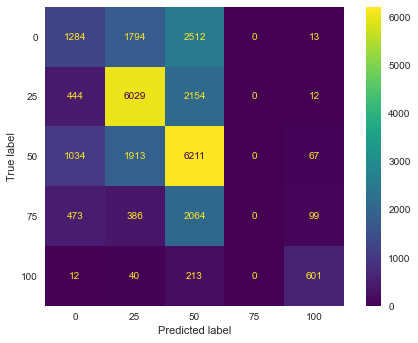

Accuracy: 0.516


In [43]:
y_predict=nn_gscv.predict(x_test)
cm = confusion_matrix(y_test, y_predict, labels=nn_gscv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=nn_gscv.classes_)
disp.plot()
plt.grid(ls='--',lw=0) 
plt.show()
accuracy_nn = accuracy_score(y_predict,y_test).round(3)
print("Accuracy:",accuracy_nn)

# Summary

In [44]:
class color:
   DARKCYAN = '\033[36m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [45]:
supervised_mls=["knn","rf","gb","nn"]
print(color.DARKCYAN + color.UNDERLINE + color.BOLD+"SUMMARY:" + color.END)
print(color.BOLD + "Method\t","Accuracy\t","Calculing time(on RAM of 16MB)"+ color.END)
for ml in supervised_mls:
    print(f"{ml.upper()}\t","{}\t\t".format(eval(f"accuracy_{ml}")),eval(f"time_{ml}"))

SUMMARY:
Method	 Accuracy	 Calculing time(on RAM of 16MB)
KNN	 0.52		 0:00:07
RF	 0.525		 0:00:04
GB	 0.527		 0:00:26
NN	 0.516		 0:33:48
